# BEST CITY TO ALLOCATE A GAMING COMPANY

## Libraries

In [6]:
import pandas as pd
import numpy as np
import requests
import math
import os
from dotenv import load_dotenv

from pymongo import MongoClient

import geopandas as gpd
from geopy.distance import distance
from geopy.distance import geodesic 
from shapely.geometry import Point
from geopy.distance import great_circle
from descartes import PolygonPatch

import matplotlib.pyplot as plt
%matplotlib inline

from cartoframes.viz import Map, Layer
from cartoframes.viz.helpers import size_continuous_layer
from cartoframes.viz.widgets import histogram_widget

import folium
from folium import plugins
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

## MongoDB - Companies Data

In [7]:
#Importing companies.json from mongodb.
client = MongoClient("mongodb://localhost/companies")
db = client.get_database()

Importing companies data from MongoDB.

Filtering by gaming/video companies and the employees > 10 prs.

In [8]:
query={"$and":[{"category_code":{"$eq":"games_video"}},{"number_of_employees":{"$gte":10}}]}
list_companies=list(db['companies'].find((query),{"category_code":1,'number_of_employees':1,'name':1,"total_money_raised":1,"offices":1,'_id':0}).sort("number_of_employees",-1))

In [9]:
#Converting the info into 'pandas'
df = pd.DataFrame(list_companies)

In [10]:
#Removing duplicates.
df = df.drop_duplicates(subset='name', keep='first')

In [11]:
#Removing the NAN values from offices column.
df.dropna(subset=['offices'], inplace=True)

In [12]:
#Removing the lists from offices column 
df = df.explode('offices')

In [13]:
#Expand information from offices column.
exapand_office_column = df[["offices"]].apply(lambda r: r.offices, result_type="expand", axis=1)
data_expanded = pd.concat([df,exapand_office_column], axis=1)
data_expanded.head()

,name,category_code,number_of_employees,total_money_raised,offices,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude
0,Comcast,games_video,100000,$725M,"{'description': 'One Comcast Center', 'address...",One Comcast Center,1701 JFK Blvd,,19103,Philadelphia,PA,USA,39.952576,-75.165252
1,The Walt Disney Company,games_video,25000,$0,"{'description': None, 'address1': '500 S. Buen...",None,500 S. Buena Vista St.,,91521,Burbank,CA,USA,34.156802,-118.324987
2,Nintendo,games_video,5080,$0,"{'description': None, 'address1': None, 'addre...",None,None,None,None,None,None,JPN,36.204824,138.252924
3,DeNA,games_video,2192,¥2.21B,"{'description': 'Headquarters', 'address1': 'S...",Headquarters,"Shibuya Hikarie, 2-21-1","Shibuya, Shibuya-ku",150-8510,Tokyo,None,JPN,NaN,NaN
5,Netflix,games_video,2000,$230M,"{'description': None, 'address1': '100 Winches...",None,100 Winchester Circle,,95032,Los Gatos,CA,USA,37.251420,-121.968687


In [14]:
#Removing old column with lists.
df_companies = data_expanded.drop(columns=["offices"])

In [15]:
#Removing the NAN long and latt columns.
df_companies.dropna(subset=['latitude'], inplace=True)
df_companies.dropna(subset=['longitude'], inplace=True)

## TOP 5 CITIES WITH MORE GAMING COMPANIES

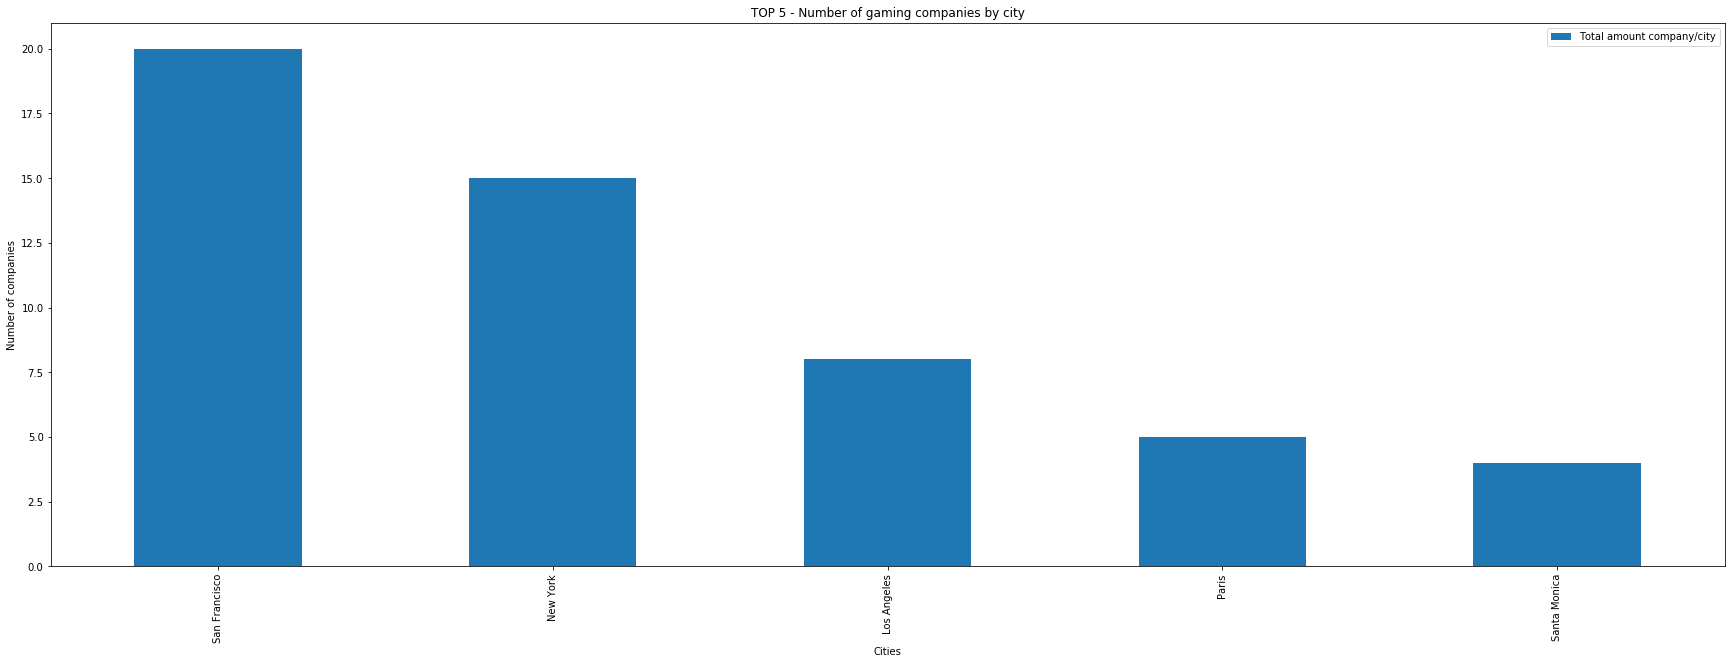

In [17]:
#TOP5 cities with more companies with 'category code' = 'video_games'

graph_df=df_companies[['city','name']]
graphic= graph_df.groupby('city').count().sort_values('name',ascending = False).head()

graphic.plot.bar(figsize=(30,10));
plt.legend(["Total amount company/city"])
plt.title("TOP 5 - Number of gaming companies by city")
plt.xlabel("Cities")
plt.ylabel("Number of companies");

# Comparing Km for Companies & Airports

### SAN FRANCISCO

1- COMPANIES

In [18]:
def geocode(address):
    data = requests.get(f"https://geocode.xyz/{address}?json=1").json()
    return {
        "type":"Point",
        "coordinates":[float(data["longt"]),float(data["latt"])]
    }
sf = geocode("San Francisco, CA, USA")
sf

{'type': 'Point', 'coordinates': [-122.40438, 37.66873]}

In [19]:
def withGeoQuery(location,maxDistance=15000,minDistance=0,field="location"):
    return {
       field: {
         "$near": {
           "$geometry": location if type(location)==dict else geocode(location),
           "$maxDistance": maxDistance,
           "$minDistance": minDistance
         }
       }
    }
query = withGeoQuery(sf)

In [21]:
#There are 18 gaming companies - 15 Km.
comp = list(db["cleancompanies"].find(query))
print(len(comp))

18


2- AIRPORT

In [59]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='San Francisco Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_sf_airport=(data['results'][0]['geometry']['location']['lat'])
long_sf_airport=(data['results'][0]['geometry']['location']['lng'])
print('Lat. = ',lat_sf_airport)
print('Long = ',long_sf_airport)

Python-dotenv could not parse statement starting at line 2


Lat. =  37.6213129
Long =  -122.3789554


In [72]:
#KM between airport & city

sf = (37.66873,-122.40438) 
airport_sf = (37.6213129,-122.3789554) 
print('Km from San Francisco to SF Airport =', great_circle(sf, airport_sf).km,'km')

Km from San Francisco to SF Airport = 5.728065177954947 km


### NEW YORK

1- COMPANIES 

In [24]:
def geocode(address):
    data = requests.get(f"https://geocode.xyz/{address}?json=1").json()
    return {
        "type":"Point",
        "coordinates":[float(data["longt"]),float(data["latt"])]
    }
ny = geocode("New York, USA")
ny

{'type': 'Point', 'coordinates': [-73.9586, 40.68908]}

In [25]:
def withGeoQuery(location,maxDistance=15000,minDistance=0,field="location"):
    return {
       field: {
         "$near": {
           "$geometry": location if type(location)==dict else geocode(location),
           "$maxDistance": maxDistance,
           "$minDistance": minDistance
         }
       }
    }
query = withGeoQuery(ny)

In [26]:
#There are 17 gaming companies - 15 Km.
comp = list(db["cleancompanies"].find(query))
print(len(comp))

17


2- AIRPORT

In [52]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='New York KFC Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_ny_airport=(data['results'][0]['geometry']['location']['lat'])
long_ny_airport=(data['results'][0]['geometry']['location']['lng'])
print('Lat. = ',lat_ny_airport)
print('Long = ',long_ny_airport)

Python-dotenv could not parse statement starting at line 2


Lat. =  40.6413111
Long =  -73.77813909999999


In [71]:
#KM between airport & city

ny = (40.68908,-73.9586) 
airport_ny = (40.6413111,-73.77813909999999) 
print('Km from NY to NY Airport =', great_circle(ny, airport_ny).km,'km')

Km from NY to NY Airport = 16.12113145961942 km


### LOS ANGELES

1- COMPANIES

In [30]:
def geocode(address):
    data = requests.get(f"https://geocode.xyz/{address}?json=1").json()
    return {
        "type":"Point",
        "coordinates":[float(data["longt"]),float(data["latt"])]
    }
la = geocode("Los Angeles")
la

{'type': 'Point', 'coordinates': [-118.29757, 34.04015]}

In [31]:
def withGeoQuery(location,maxDistance=15000,minDistance=0,field="location"):
    return {
       field: {
         "$near": {
           "$geometry": location if type(location)==dict else geocode(location),
           "$maxDistance": maxDistance,
           "$minDistance": minDistance
         }
       }
    }
query = withGeoQuery(la)

In [32]:
#There are 12 gaming companies - 15 Km.
comp = list(db["cleancompanies"].find(query))
print(len(comp))

12


2- AIRPORT

In [65]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Los Angeles Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_la_airport=(data['results'][0]['geometry']['location']['lat'])
long_la_airport=(data['results'][0]['geometry']['location']['lng'])
print('Lat. = ',lat_la_airport)
print('Long = ',long_la_airport)

Python-dotenv could not parse statement starting at line 2


Lat. =  33.9415889
Long =  -118.40853


In [70]:
#KM between airport & city

la = (34.04015,-118.29757) 
airport_la = (33.9415889,-118.40853) 
print('Km from LA to LA Airport =', great_circle(la, airport_la).km,'km')

Km from LA to LA Airport = 14.992077104477458 km


### PARIS

1- COMPANIES

In [34]:
def geocode(address):
    data = requests.get(f"https://geocode.xyz/{address}?json=1").json()
    return {
        "type":"Point",
        "coordinates":[float(data["longt"]),float(data["latt"])]
    }
paris = geocode("Paris")
paris

{'type': 'Point', 'coordinates': [2.34293, 48.85717]}

In [35]:
def withGeoQuery(location,maxDistance=15000,minDistance=0,field="location"):
    return {
       field: {
         "$near": {
           "$geometry": location if type(location)==dict else geocode(location),
           "$maxDistance": maxDistance,
           "$minDistance": minDistance
         }
       }
    }
query = withGeoQuery(paris)

In [36]:
#There are 4 gaming companies - 15 Km.
comp = list(db["cleancompanies"].find(query))
print(len(comp))

4


2- AIRPORT

In [64]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Paris-Charles De Gaulle'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_paris_airport=(data['results'][0]['geometry']['location']['lat'])
long_paris_airport=(data['results'][0]['geometry']['location']['lng'])
print('Lat. = ',lat_paris_airport)
print('Long = ',long_paris_airport)

Python-dotenv could not parse statement starting at line 2


Lat. =  49.0096906
Long =  2.5479245


In [69]:
#KM between airport & city

paris = (48.85717,2.34293) 
airport_paris = (49.0096906,2.5479245) 
print('Km from Paris to Paris-Charles De Gaulle =', great_circle(paris, airport_paris).km,'km')

Km from Paris to Paris-Charles De Gaulle = 22.62430090103764 km


### SANTA MONICA

1- COMPANIES

In [38]:
def geocode(address):
    data = requests.get(f"https://geocode.xyz/{address}?json=1").json()
    return {
        "type":"Point",
        "coordinates":[float(data["longt"]),float(data["latt"])]
    }
sm = geocode("Santa Monica, CA, USA")
sm

{'type': 'Point', 'coordinates': [-118.48319, 34.02401]}

In [41]:
def withGeoQuery(location,maxDistance=15000,minDistance=0,field="location"):
    return {
       field: {
         "$near": {
           "$geometry": location if type(location)==dict else geocode(location),
           "$maxDistance": maxDistance,
           "$minDistance": minDistance
         }
       }
    }
query = withGeoQuery(sm)

In [78]:
#There are 4 gaming companies - 15 Km.
comp = list(db["cleancompanies"].find(query))
print(len(comp),'companies')

12 companies


2- AIRPORT

In [79]:
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
address='Santa Monica Airport'
data = requests.get(f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={token}").json()
lat_paris_airport=(data['results'][0]['geometry']['location']['lat'])
long_paris_airport=(data['results'][0]['geometry']['location']['lng'])
print('Lat. = ',lat_paris_airport)
print('Long. = ',long_paris_airport)

Python-dotenv could not parse statement starting at line 2


Lat. =  34.0178143
Long. =  -118.4473286


In [76]:
#KM between airport & city

sm = (34.02401,-118.48319) 
airport_sm = (34.0178143,-118.4473286) 
print('Km from Santa Monica to Santa Monica Airport =', great_circle(sm, airport_sm).km,'km')

Km from Santa Monica to Santa Monica Airport = 3.3761049677896473 km


### CONCLUSION:

The chosen city is Santa Monica, since it has the nearest airport and has a huge amount of companies around.

## Convertig DataFrame into GeoDataFrame

In [83]:
gdf = gpd.GeoDataFrame(df_companies, geometry=gpd.points_from_xy(df_companies.longitude, df_companies.latitude))

In [85]:
#Adding Airport on heatmap.
start_lat = 34.02401
start_lon = -118.48319
heat_m_sm = folium.Map(location=[start_lat, start_lon],tiles='cartodbpositron', zoom_start=15)
Marker([start_lat, start_lon], icon=folium.Icon(color='black')).add_to(heat_m_sm)

In [87]:
#Printing companies on heatmap.
companies = gdf
companies_group = folium.FeatureGroup(name="Gaming Companies")
HeatMap(data=companies[['latitude', 'longitude']],radius=15).add_to(companies_group)
companies_group.add_to(heat_m_sm)

In [101]:
#ADDING AIRPORT COORDINATES
airport_long, airport_lat = -118.4459796197085, 34.01916328029149
heat_m_sm=heat_m_sm.add_child(Marker([airport_lat, airport_long], icon=folium.Icon(color='lightblue')))

In [107]:
#ADDING NURSERIES
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
location="34.02401,-118.48319"
site='nursery'
data=requests.get(f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={location}&radius=5000&type={site}&keyword=cruise&key={token}").json()

Python-dotenv could not parse statement starting at line 2


In [108]:
#Extracting the info of results column. Splitting the information in order to get lat and lng.
df_nurseries_sm=pd.DataFrame(data['results'])
exapand_office_column = df_nurseries_sm[["geometry"]].apply(lambda r: r.geometry, result_type="expand", axis=1)
data_expanded_nur = pd.concat([df_nurseries_sm,exapand_office_column], axis=1)
exapand_loc_column = data_expanded_nur[["location"]].apply(lambda r: r.location, result_type="expand", axis=1)
data_expanded_nur_1 = pd.concat([data_expanded_nur,exapand_loc_column], axis=1)

In [109]:
#Exporting nurseries file info into Finder.
data_expanded_nur_1.to_json('sf_nurseries.json',orient='records')

In [100]:
#Converting Pandas to Geopandas.
gdf_nursery = gpd.GeoDataFrame(data_expanded_nur_1, geometry=gpd.points_from_xy(data_expanded_nur_1.lng, data_expanded_nur_1.lat))

In [105]:
#Adding nurseries on map.
nursery = gdf_nursery[['lat', 'lng']]
nursery_group = folium.FeatureGroup(name="Nurseries")
nursery_group.add_child(MarkerCluster(locations=nursery[['lat', 'lng']]))
heat_m_sm.add_child(nursery_group)

In [110]:
#ADDING PUBs
load_dotenv()
token = os.getenv("TOKEN_GOOGLE")
location="34.02401,-118.48319"
site='pub'
data=requests.get(f"https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={location}&radius=5000&type={site}&keyword=cruise&key={token}").json()

Python-dotenv could not parse statement starting at line 2


In [113]:
#Extracting the info of results column. Splitting the information in order to get lat and lng.
df_pubs=pd.DataFrame(data['results'])
exapand_pubs = df_pubs[["geometry"]].apply(lambda r: r.geometry, result_type="expand", axis=1)
data_expanded_pub= pd.concat([df_pubs,exapand_office_column], axis=1)
exapand_loc_column = data_expanded_nur[["location"]].apply(lambda r: r.location, result_type="expand", axis=1)
data_expanded_pub_1 = pd.concat([data_expanded_nur,exapand_loc_column], axis=1)

In [115]:
#Converting Pandas to Geopandas.
gdf_pubs_geo = gpd.GeoDataFrame(data_expanded_pub_1, geometry=gpd.points_from_xy(data_expanded_pub_1.lng, data_expanded_pub_1.lat))

In [116]:
#Adding pubs on map.
pubs = gdf_pubs_geo[['lat', 'lng']]
pubs_group = folium.FeatureGroup(name="Pubs")
pubs_group.add_child(MarkerCluster(locations=gdf_pubs_geo[['lat', 'lng']]))
heat_m_sm.add_child(pubs_group)